In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pgf.texsystem'] = "pdflatex"
matplotlib.rcParams.update({'font.family': "serif", 'font.size': 10})
matplotlib.rcParams['text.usetex'] = True

import time

np.random.seed(1234)

## Introduction

This jupyter notebook provides a baseline implemenation of time-consistent PINNs for a simple system of ODEs of size two. The code is structured as follows:

1) A DNN class to define an MLP of arbitrary layer size with Tanh activation. In the tcPINN implementation, the inputs of the DNN will correspond to the time and the initial state (t, $y_0$).

2) A TcPINN class implementing the time-consistent physics-informed neural network. The input of the network are the time and the initial state (t, $y_0$) of the ODE solution. The output is $y_0 + t \cdot N(t, y_0)$, where $N$ is a user defined DNN, and approximates the solution of the ODE at time $t$ with initial state $y_0$. This class includes the definition of the PINN-loss, and the semgigroup- and smoothness-loss functions - the two key contributions of our project.

3) An example of how to generate the training data points and train a tcPINN.

4) A visualization of the predicted time-consistent ODE solution beyond the maximum time in the training dataset.

5) An evaluation of the tcPINN measuring the average Euclidean distance of points on the predicted solution to the (a priori known) true solution.

We consider the linear ODE

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}(t) = \begin{pmatrix} -y_2 \\ y_1 \end{pmatrix} (t).
\end{align*}

For a given initial state $y_0 = (y_0^1, y_0^2) \in \mathbb{R}^2$, the solution $(y(t))_{t\geq0}$ flows in counter clockwise circles and is given by

\begin{align*}
    y(t) = \begin{pmatrix} y_0^1 \cos(t) - y_0^2 \sin(t) \\ y_0^2 \cos(t) + y_0^1 \sin(t) \end{pmatrix}.
\end{align*}

In [2]:
def solution_simple_ODE(t, y0):
    
    y1t = y0[0] * np.cos(t) - y0[1] * np.sin(t)
    y2t = y0[1] * np.cos(t) + y0[0] * np.sin(t)

    return np.array([y1t, y2t])

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()
        
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        layer_list = list()
        
        for i in range(self.depth - 1):
            
            layer_list.append(
                (f"layer_{i}", torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append((f"activation_{i}", self.activation()))
            
        layer_list.append(
            (f"layer_{self.depth - 1}", torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)

In [64]:
# TcPINN: Time-consistent physics-informed neural network
class TcPINN():

    def __init__(self, layers, T, X_pinn, X_semigroup, X_smooth, X_data, data):

        # neural network
        self.dnn = DNN(layers).to(device)
        self.ode_dimension = layers[-1]
        
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)
        
        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        self.t_data = torch.tensor(X_data[:, :1], requires_grad=True).float().to(device)
        self.y_data = torch.tensor(X_data[:, 1:], requires_grad=True).float().to(device)
        self.data = torch.tensor(data, requires_grad=True).float().to(device)
        
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), lr=1.0, max_iter=50000, max_eval=50000, 
            history_size=10, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # M(t, y0) = y0 + t N(t, y0) guarantees continuity
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivatives of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for _ in range(self.ode_dimension)]
        
        for i, vec in enumerate(vectors):
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def _loss_pinn(self):
        """
        The ODE specific classical PINN loss.
        """
        y = self.net_y(self.t_pinn, self.y_pinn)
        deriv = self.net_derivative(self.t_pinn, self.y_pinn)
        
        loss1 = torch.mean((deriv[0] + y[:,1:2]) ** 2)
        loss2 = torch.mean((deriv[1] - y[:,0:1]) ** 2)
        loss = loss1 + loss2
        
        return loss
    
    
    def _loss_semigroup(self):
        """
        The general semigroup loss.
        """
        y_no_restart = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_restart = self.net_y(self.t_semigroup, y_s)
        loss = self.ode_dimension * torch.mean((y_no_restart - y_restart) ** 2)
        
        return loss
    
    
    def _loss_smooth(self):
        """
        The general smoothness loss.
        """
        deriv_below = self.net_derivative(self.t_smooth, self.y_smooth)
        y = self.net_y(self.t_smooth, self.y_smooth)
        deriv_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y)
        
        loss = .0
        
        for d1, d2 in zip(deriv_below, deriv_above):
            loss += torch.mean((d1 - d2) ** 2)
        
        return loss
    
    
    def _loss_data(self):
        """
        The general data loss.
        """
        y = self.net_y(self.t_data, self.y_data)
        loss = self.ode_dimension * torch.mean((y - self.data) ** 2)
        
        return loss
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        loss = .0
        
        if self.use_standard:
            
            loss_pinn = self._loss_pinn()
            loss += loss_pinn
        
        if self.use_semigroup:
            
            loss_semigroup = self._loss_semigroup()
            loss += loss_semigroup
        
        if self.use_smoothness:
            
            loss_smooth = self._loss_smooth()
            loss += loss_smooth
        
        if self.use_data:
            
            loss_data = self._loss_data()
            loss += loss_data
        
        loss.backward()       
        self.iter += 1
        
        if self.iter % 100 == 0:
            
            track = f"iteration {self.iter}, loss: {loss.item():.4f}"
            
            if self.use_standard:
                track += f", PINN loss: {loss_pinn.item():.4f}"
            
            if self.use_semigroup:
                track += f", semigroup loss: {loss_semigroup.item():.4f}"
            
            if self.use_smoothness:
                track += f", smoothness loss: {loss_smooth.item():.4f}"
            
            if self.use_data:
                track += f", data loss: {loss_data.item():.4f}"
            
            print(track)
        
        return loss    
    
    
    def train(self, use_standard=True, use_semigroup=True, use_smoothness=True, use_data=False):
        
        assert any([use_standard, use_semigroup, use_smoothness, use_data]), \
            "At least one loss function has to be used"
        
        self.use_standard = use_standard
        self.use_semigroup = use_semigroup
        self.use_smoothness = use_smoothness
        self.use_data = use_data
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

### Training Example

In [65]:
def sample_circle(max_radius, n_samples):
    
    length = np.sqrt(np.random.uniform(0, max_radius ** 2, size=n_samples))
    angle = np.pi * np.random.uniform(0, 2, size=n_samples)

    y0 = length * np.cos(angle)
    y1 = length * np.sin(angle)
    points = np.stack([y0, y1], axis=0).T
    
    return points 

In [70]:
layers = [3, 32, 32, 32, 32, 32, 2]

T = 1
max_radius = 3

# training samples
N_pinn = 1000
t_pinn = np.random.uniform(0, T, size=(N_pinn, 1))
y_pinn = sample_circle(max_radius, N_pinn)
X_pinn = np.hstack([t_pinn, y_pinn])

N_semigroup = 1000
r1 = np.random.uniform(0, 1, size=N_semigroup)
r2 = np.random.uniform(0, 1, size=N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = sample_circle(max_radius, N_semigroup)
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])

N_smooth = 1000
t_smooth = np.random.uniform(0, T, size=(N_smooth, 1))
y_smooth = sample_circle(max_radius, N_smooth)
X_smooth = np.hstack([t_smooth, y_smooth])

N_data = 1000
t_data = np.random.uniform(0, T, size=(N_data, 1))
y_data = sample_circle(max_radius, N_data)
X_data = np.hstack([t_data, y_data])
data = np.array([
    solution_simple_ODE(t, y0) for t, y0 in zip(t_data.flatten(), y_data)
])

In [71]:
model = TcPINN(
    layers=layers, T=T, 
    X_pinn=X_pinn, X_semigroup=X_semigroup, 
    X_smooth=X_smooth, X_data=X_data, data=data
)

In [72]:
%%time
               
model.train(use_standard=True, use_semigroup=False, use_smoothness=True, use_data=True)

iteration 100, loss: 0.0166, PINN loss: 0.0071, smoothness loss: 0.0085, data loss: 0.0010
iteration 200, loss: 0.0032, PINN loss: 0.0016, smoothness loss: 0.0011, data loss: 0.0004
iteration 300, loss: 0.0014, PINN loss: 0.0007, smoothness loss: 0.0005, data loss: 0.0002
iteration 400, loss: 0.0006, PINN loss: 0.0003, smoothness loss: 0.0003, data loss: 0.0001


KeyboardInterrupt: 

## Predict and Plot the Solution

In [25]:
def predict_standard(model, y0, max_t_pred, delta_t):
    
    times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    times = times[:, np.newaxis]
    
    y0 = np.array([y0 for _ in range(len(times))])
    trajectory =  model.predict(times, y0)
    
    return trajectory


def predict_tc(model, y0, max_t_pred, delta_t):
    """
    detla_t should devide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, model.T + delta_t, delta_t)[1:]
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / model.T))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

In [26]:
# Note that max_t is equal to 1 during training
y0 = [1., 0.]
max_t_pred = 7.
delta_t = 0.05

validation_standard = predict_standard(model, y0, max_t_pred, delta_t)
validation_tc = predict_tc(model, y0, max_t_pred, delta_t)

true_solution = np.array([
    solution_simple_ODE(t, y0) 
    for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
])

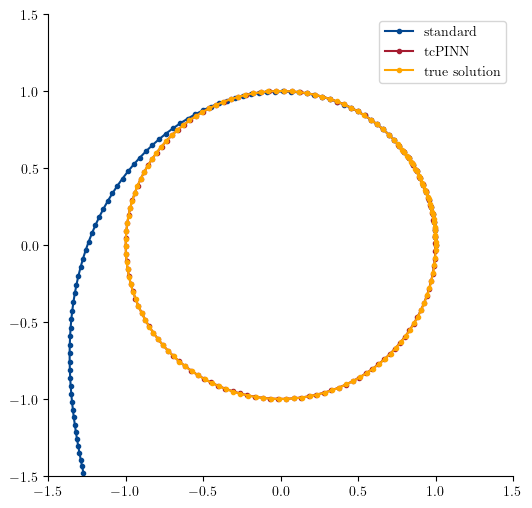

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.spines[['top', 'right']].set_visible(False)

radius = np.max(np.abs(y0)) + .5
ax.set_xlim([-radius, radius])
ax.set_ylim([-radius, radius])    

ax.plot(validation_standard[:,0], validation_standard[:,1], '.-', label="standard", color="#03468F")
ax.plot(validation_tc[:,0], validation_tc[:,1], '.-', label="tcPINN", color="#A51C30")
ax.plot(true_solution[:,0], true_solution[:,1], '.-', label="true solution", color="orange")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

## Evaluation

In [28]:
def evaluate(model, n_evaluate, max_t, delta_t):
    
    evaluation_times = np.linspace(0, max_t, int(max_t / delta_t) + 1)
    n_timepoints = len(evaluation_times)
    
    errors_standard = np.empty((n_evaluate, n_timepoints), dtype=float)
    errors_tc = np.empty((n_evaluate, n_timepoints), dtype=float)
    
    y0s = sample_circle(max_radius, n_evaluate)
    
    for i, y0 in enumerate(y0s):
        
        solution_true = np.array([
            solution_simple_ODE(t, y0)
            for t in evaluation_times
        ])
        
        solution_standard = predict_standard(model, y0, max_t, delta_t)
        errors_standard[i] = np.sqrt(np.sum((solution_standard - solution_true) ** 2, axis=1))
        
        solution_tc = predict_tc(model, y0, max_t, delta_t)
        errors_tc[i] = np.sqrt(np.sum((solution_tc - solution_true) ** 2, axis=1))
    
    return errors_standard, errors_tc

In [84]:
n_evaluate = 1000
max_t = 2.
delta_t = .1

errors_standard, errors_tc = evaluate(model, n_evaluate, max_t, delta_t)

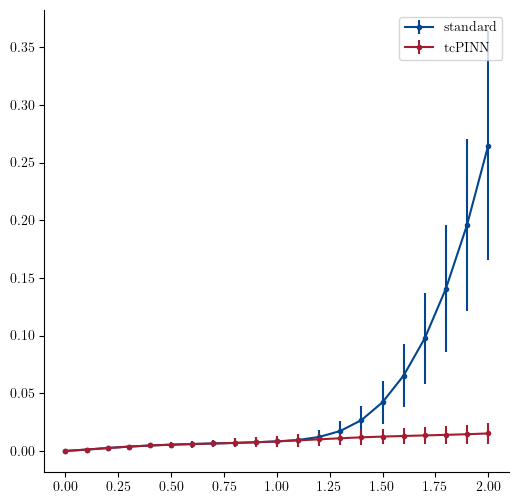

In [85]:
evaluation_times = np.linspace(0, max_t, int(max_t / delta_t) + 1)

fig, ax = plt.subplots(figsize=(6,6))
ax.spines[['top', 'right']].set_visible(False)

ax.errorbar(
    evaluation_times, np.mean(errors_standard, axis=0), np.std(errors_standard, axis=0),
    marker=".", label="standard", color="#03468F"
)
ax.errorbar(
    evaluation_times, np.mean(errors_tc, axis=0), np.std(errors_tc, axis=0),
    marker=".", label="tcPINN", color="#A51C30"
)

plt.legend()
plt.savefig("errors_over_time.pdf", bbox_inches="tight")
plt.show()